# Nonlinear seismic response of a MRF
#### March 2020, By Amir Hossein Namadchi
This is an OpenSeesPy simulation of a moment resisting frame subjected to seismic excitation. The model was introduced by *C. Kolay* & *J. M. Ricles* in their paper entitled [Assessment of explicit and semi-explicit classes of model-based algorithms for direct integration in structural dynamics](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.5153). The beams and columns of the MRF are modeled using `dispBeamColumn` fiber elements. The gravity load resisting system associated with the MRF is modeled using a lean-on column composed of linear elastic beam-column elements with 2nd Order $P-\Delta$ effects [[1]](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.5153).

![Curved Arch](MRF2LC.png)

In [1]:
import numpy as np
import opensees.openseespy as ops
import matplotlib.pyplot as plt
import sees
# %matplotlib notebook

## Units

In [2]:
from opensees.units.mks import m, N, sec, inch, kg, gravity as g
import opensees.units.mks as units

KN = N*1000
# kg *= 1000 # *= gravity #  TODO!!!!!!!!!!!
## Units
# m = 1.0               # Meters
# KN = 1.0              # KiloNewtons
# sec = 1.0             # Seconds
# inch = 0.0254*m       # inches 

# kg = KN*(sec**2)/m    # mass unit (derived)
# g = 9.81*(m/sec**2)   # gravitational constant

In [3]:
inch

0.0254

## Earthquake record
This will load *1994 Northridge* earthquake ground motion record (Canyon Country - W Lost Cany station) downloaded for the [PEER website](https://ngawest2.berkeley.edu/). Then, the record is scaled by a factor of **3** as follows (scaling could also be done when defining `timeSeries`):

In [4]:
dt = 0.01*sec
northridge = np.loadtxt('RSN960_NORTHR_LOS270.AT2', skiprows=4).flatten()
northridge = np.column_stack((np.arange(0,len(northridge)*dt, dt),
                northridge*3*g))

## Model Definition
### Geometry
Node coordinates and element connectivity are defined.

In [5]:

model = ops.Model(ndm=2, ndf=3)

## Main Nodes
# Node Coordinates Matrix (size : nn x 2)
node_coords = np.array([[0,0],[6,0],
                        [0,1],[6,1],
                        [0,2],[6,2],
                        [0,2.5],[6,2.5],
                        [0,3],[0.5,3],[1,3],[3,3],[5,3],[5.5,3],[6,3],
                        [0,3.5],[6,3.5],
                        [0,4],[6,4],
                        [0,5],[6,5],
                        [0,5.5],[6,5.5],
                        [0,6],[0.5,6],[1,6],[3,6],[5,6],[5.5,6],[6,6]
                       ], dtype = np.float64)*m
## Main Elements
# Element Connectivity Matrix (size: nel x 2)
connectivity = [[1, 3], [3, 5], [5, 7], [7, 9],
                [9, 10], [10, 11], [11, 12], [12, 13],
                [13, 14], [14, 15], [15, 8], [8, 6],
                [6, 4], [4, 2], [9, 16], [16, 18],
                [18, 20], [20, 22], [22, 24], [24, 25],
                [25, 26], [26, 27], [27, 28], [28, 29],
                [29, 30], [30, 23], [23, 21], [21, 19],
                [19, 17], [17, 15]]

# Get Number of elements
nel = len(connectivity)

# Distinguish beams and columns by their element tag ID
all_the_beams = list(range(5, 10+1)) + list(range(20, 25+1))
all_the_cols = list(np.setdiff1d(np.arange(1, nel+1),
                                 all_the_beams))

### Sections & Material
sections are defined in `dict` which is quite self-explanatory.

In [6]:
# Main Beams and Columns
sections = {'W24x55':{'d':23.57*inch, 'tw':0.395*inch,
                      'bf':7.005*inch, 'tf':0.505*inch,
                      'A':16.2*(inch**2),
                      'I1':1350*(inch**4), 'I2':29.1*(inch**4)},
            
            'W14x120':{'d':14.48*inch, 'tw':0.590*inch,
                      'bf':14.670*inch, 'tf':0.940*inch,
                      'A':35.3*(inch**2),
                      'I1':1380*(inch**4), 'I2':495*(inch**4)}
           }

# Leaning columns section properties
leaning_col = {'A':(9.76e-2)*m**2,
               'I1':(7.125e-4)*m**4}

# Material properties
F_y = 345000*(KN/m**2)     # yield strength
E_0 = 2e8*(KN/m**2)        # initial elastic tangent
eta = 0.01                 # strain-hardening ratio
rho = 7850*(kg/m**3)       # mass density

### Adding to the Domain

In [7]:
# Nodal loads and Masses
lumped_mass = 50.97*kg     # seismic floor mass
P_1 = 500*KN               # Nodal loads

# Adding nodes to the domain
## Main Nodes
for n in range(len(node_coords)):
    model.node(n+1, *node_coords[n])

## Fictitious Nodes (Leaning columns)
model.node(100,*[7.0, 0.0])                                # @ Base
model.node(101,*[7.0, 3.0],
         '-mass', *[lumped_mass, 0.00001, 0.00001])      # @ Story 1
model.node(102,*[7.0, 6.0],
         '-mass', *[lumped_mass, 0.00001, 0.00001])      # @ Story 2 (roof)

# Material
# -> uniaxial bilinear steel material with kinematic hardening
model.uniaxialMaterial('Steel01', 1, F_y, E_0, eta)

# Adding Sections
## Beams
# model.section('WFSection2d', 1, 1,
#             sections['W24x55']['d'],
#             sections['W24x55']['tw'],
#             sections['W24x55']['bf'],
#             sections['W24x55']['tf'], 10, 3)

model.section('Fiber', 1, shape=("W24x55",  1, (10,3), units))

## Columns
model.section('Fiber', 2, shape=("W14x120", 1, (10,3), units))

In [8]:
# model.section('WFSection2d', 2, 1,
#             sections['W14x120']['d'],
#             sections['W14x120']['tw'],
#             sections['W14x120']['bf'],
#             sections['W14x120']['tf'], 10, 3)

# Boundary Conditions
## Fixing the Base Nodes
for n in [1, 2, 100]:
    model.fix(n, 1, 1, 0)

## Rigid floor diaphragm
model.equalDOF(12, 101, 1)
model.equalDOF(27, 102, 1)

# Transformations & Integration
## Transformation
model.geomTransf('Linear', 1)    # For Beams
model.geomTransf('PDelta', 2)    # For leaning Columns
## Integration scheme
model.beamIntegration('Lobatto', 1, 1, 5)   # For Beams
model.beamIntegration('Lobatto', 2, 2, 5)   # For Columns

# Adding Elements
## Beams
for e in all_the_beams:
    model.element('DispBeamColumn',
            e, *connectivity[e-1], 1, 1,
            '-cMass', rho*sections['W24x55']['A'])

## Columns
## -> OpenseesPy cannot handle numpy int types
## -> so I had to convert them to primitive python int type
for e in list(map(int, all_the_cols)):
     model.element('DispBeamColumn', e, *connectivity[e-1], 1, 2,
             '-cMass', rho*sections['W14x120']['A'])


## Leaning Columns
model.element('ElasticBeamColumn', nel+1, *[100, 101],
            leaning_col['A'], E_0, leaning_col['I1'], 2)
model.element('ElasticBeamColumn', nel+2, *[101, 102],
            leaning_col['A'], E_0, leaning_col['I1'], 2)

### Draw Model
The model can now be drawn using `sees`:

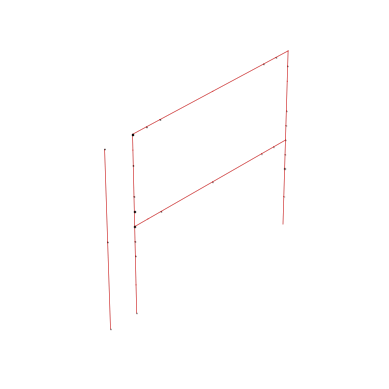

In [13]:
sees.render(model)
model.print("-json", file="model.json")

### Damping Model
The model assumes 2% damping for the first and second modes of the system according to rayleigh's damping model. for two modes, the damping coefficients can be obtained by:

$$ \left( \begin{array}{l}
{\alpha _0}\\
{\alpha _1}
\end{array} \right) = 2\frac{{{\omega _m}{\omega _n}}}{{\omega _n^2 - \omega _m^2}}\left[ {\begin{array}{*{20}{c}}
{{\omega _n}}&{ - {\omega _m}}\\
{ - 1/{\omega _n}}&{1/{\omega _m}}
\end{array}} \right]\left( \begin{array}{l}
{\zeta _m}\\
{\zeta _n}
\end{array} \right)\ $$

So, we need to perform an eigen analysis to obtain first two natural frequencies.

In [10]:
# Building Rayleigh damping model
omega = np.sqrt(model.eigen('-fullGenLapack', 2))
print('Two first periods are:', 2*np.pi/omega)

a_m, b_k = 2*((omega[0]*omega[1])/(omega[1]**2-omega[0]**2))*(
    np.array([[omega[1],-omega[0]],
              [-1/omega[1],1/omega[0]]])@np.array([0.02,0.02]))
## Rayleigh damping based on initial stiffness
model.rayleigh(a_m, 0, b_k, 0)

Two first periods are: [1.17694844e-06 1.74174909e-07]


## Analysis
### Gravity Analysis

In [11]:
# Time Series
model.timeSeries('Linear', 1)                    # For gravitional loads

# Load Pattern
model.pattern('Plain', 1, 1)
model.load(101, *[0.0, -P_1, 0.0])
model.load(102, *[0.0, -P_1, 0.0])

# Settings
model.constraints('Transformation')
model.numberer('RCM')
model.system('ProfileSPD')
model.test('NormUnbalance', 0.000001, 100)
model.algorithm('Newton')
model.integrator('LoadControl', 0.1)
model.analysis('Static')

# Perform static analysis
assert model.analyze(10) == 0

StaticAnalysis::analyze - the Algorithm failed at step: 0 with domain at load factor 0.1


AssertionError: 

### Time History Analysis

In [ ]:
# Set time to zero
model.loadConst('-time', 0.0)
model.wipeAnalysis()

# Time Series
model.timeSeries('Path', 2, dt=dt,           # For EQ 
                 values=northridge[:,1],
                 time = northridge[:,0])

# Load Pattern
model.pattern('UniformExcitation', 2, 1, '-accel', 2)


# Settings
model.constraints('Plain')
model.numberer('RCM')
model.system('ProfileSPD')
model.test('NormUnbalance', 0.0000001, 100)
model.algorithm('Newton')
model.integrator('Newmark', 0.5, 0.25)
model.analysis('Transient')

# Record some responses to plot
time_lst =[]     # list to hold time stations for plotting
d_lst = []      # list to hold roof displacments
for i in range(len(northridge)):
    model.analyze(1, dt)
    time_lst.append(model.getTime())
    d_lst.append(model.nodeDisp(27,1))    

## Visualization
Time history of the horizontal displacement of the roof is plotted here

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(time_lst, np.array(d_lst), color = '#d62d20', linewidth=1.75)
plt.ylabel('Horizontal Displacement (m)', {'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontstyle':'italic','size':14})
plt.grid()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14);

### References
- <blockquote>Kolay, C. and Ricles, J.M., 2016. Assessment of explicit and semi‐explicit classes of model‐based algorithms for direct integration in structural dynamics. International Journal for Numerical Methods in Engineering, 107(1), pp.49-73.</blockquote>